In [2]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
using LinearAlgebra
using DoubleFloats

In [70]:
# create functionals
μ = 1
ρ = 1
@variables ϵ r x₁ x₂ ;
ϕ1 = r^7
ϕ2 = r^3

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]
display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
#display(F_A)
F_A = compile_kernel_array(F_A)
F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
F_B = compile_kernel_array(F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
display(P_list)

F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
display(F_PA)
F_PA = compile_polynomials(F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
display(F_PB)
F_PB = compile_polynomials(F_PB)

N_poly = size(F_PA)[2]

println("done")

3×3 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                                    0     sqrt(x₁^2 + x₂^2)^3

25-element Vector{Any}:
 Num[1, 0.0, 0.0]
 Num[x₂, 0.0, 0.0]
 Num[x₁, -x₂, 0.0]
 Num[x₂^2, 0.0, 0.0]
 Num[x₁*x₂, (-1//2)*(x₂^2), 0.0]
 Num[x₁^2, -2x₁*x₂, 0.0]
 Num[x₂^3, 0.0, 0.0]
 Num[x₁*(x₂^2), (-1//3)*(x₂^3), 0.0]
 Num[x₂*(x₁^2), -x₁*(x₂^2), 0.0]
 Num[x₁^3, -3x₂*(x₁^2), 0.0]
 Num[x₂^4, 0.0, 0.0]
 Num[x₁*(x₂^3), (-1//4)*(x₂^4), 0.0]
 Num[(x₁^2)*(x₂^2), (-2//3)*x₁*(x₂^3), 0.0]
 Num[x₂*(x₁^3), (-3//2)*(x₁^2)*(x₂^2), 0.0]
 Num[x₁^4, -4x₂*(x₁^3), 0.0]
 Num[0, 1, 0.0]
 Num[0, x₁, 0.0]
 Num[0, x₁^2, 0.0]
 Num[0, x₁^3, 0.0]
 Num[0, x₁^4, 0.0]
 Num[0.0, 0.0, x₂]
 Num[0.0, 0.0, x₁]
 Num[0.0, 0.0, x₂^2]
 Num[0.0, 0.0, x₁*x₂]
 Num[0.0, 0.0, x₁^2]

6×25 Matrix{Num}:
 1    x₂     x₁    x₂^2             x₁*x₂    …  0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)       0.0  0.0    0.0   0.0    0.0
 0.0   0.0    0.0    -2.0               0.0     0.0  1.0    0.0  x₂    2x₁
 0.0   0.0    0.0     0.0               1.0     1.0  0.0  2x₂    x₁      0.0
 1    x₂     x₁    x₂^2             x₁*x₂       0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)    …  0.0  0.0    0.0   0.0    0.0

2×25 Matrix{Num}:
 0.0  0.0  0.0  -2.0  0.0  -2.0  -6.0x₂  …  0.0  1.0    0.0  x₂  2x₁
 0.0  0.0  0.0   0.0  1.0   0.0   0.0       1.0  0.0  2x₂    x₁    0.0

done


In [71]:
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

#= u = 20*x*y^3
v = 5*x^4 - 5*y^4
p = 60*x*x*y - 20*y*y*y =#
display(dx(u)+dy(v))
f1 = 0#-dx(dx(u)) - dy(dy(u)) + dx(p)
f2 = 0#-dx(dx(v)) - dy(dy(v)) + dy(p)
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
true_v1 = eval(build_function(u,x,y))
true_v2 = eval(build_function(v,x,y))
f1(12,2)


0

0

0

0

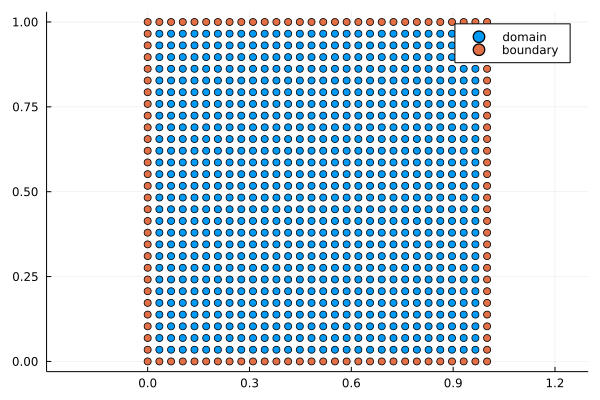

In [75]:
# create points 
N_side = 30
I_points, B_points = generate_2D_equally_spaced_points(N_side)
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
#all_points = [domain_p boundary_p]
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [76]:
# assemble matrices and rhs 

param = 5
r = 4.01*1.45/(N_side-1)
I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
G = zeros(2*N_I,2*N_I) # global sprse matrix 
Global_RHS = zeros(2*N_I)
cond_num_array = zeros(N_I)
for i in 1:N_I
    I_idx = inrange(I_tree, I_points[:,i], r, true)
    I_idx = deleteat!(I_idx,findall(x->x==i,I_idx))

    B_idx = inrange(B_tree, I_points[:,i], r, true)
    Local_B_points = B_points[:,B_idx] .- reshape(I_points[:,i],(2,1))
    Local_I_points = I_points[:,I_idx] .- reshape(I_points[:,i],(2,1))
    #display(Local_I_points)
    Full_Local_I_points = hcat(I_points[:,i],I_points[:,I_idx]) .- reshape(I_points[:,i],(2,1))# internal points including center 
    #display(Full_Local_I_points)
    default_point_list = [Full_Local_I_points,Full_Local_I_points,Local_I_points,Local_I_points] # list of points if no boundary is present
    sample_point_list = [reshape([0.0,0.0],(2,1)),reshape([0.0,0.0],(2,1))]
    #sample_point_list = [reshape(I_points[:,i],(2,1)),reshape(I_points[:,i],(2,1))]
    L_RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
    if isempty(B_idx)
        # No boundary points nearby
        #T = point_difference_tensor(Points,Points)
        PA = generate_P_matrix(default_point_list,F_PA[1:end-2,:])
        
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A[1:4,1:4],T,param))
        B = flatten(generate_block_matrices(F_B[:,1:4],T2,param))
        RHS = vcat(L_RHS,zeros(N_poly))

    else
        append!(default_point_list,[Local_B_points,Local_B_points])
        PA = generate_P_matrix(default_point_list,F_PA[1:end,:])
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A,T,param))
        B = flatten(generate_block_matrices(F_B,T2,param))
        RHS = vcat(L_RHS,true_v1.(B_points[1,B_idx],B_points[2,B_idx]),true_v2.(B_points[1,B_idx],B_points[2,B_idx])
        ,zeros(N_poly))

    end
    O = zeros(N_poly,N_poly)
 
    cond_num_array[i] = cond([A PA;PA' O])
    PB = generate_P_matrix(sample_point_list,F_PB)
    N_I_local = length(I_idx)+1 # total number of local internal points counting the center
    #A = Double64.(A)
    C = [B PB]*inv(([A PA;PA' O]))
    #C = B*inv(A)
    #display(C)
    #C = Float64.(C)
    #println([i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I))
    #display(C[:,1:2*N_I_local])
    G[[i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I)] .= C[:,1:2*N_I_local]
    #println(size(C[:,1+2*N_I_local:end]),size(RHS))
    Global_RHS[[i,N_I+i]] .= -(C[:,1+2*N_I_local:end] * RHS) 
    #display(maximum(abs.(inv(A)*A .- Matrix(I(size(A)[1])))))
    
    
    #println(i,"  ",I_idx)
end
println("max local cond number: ",maximum(cond_num_array))
#println("global condition number: ",cond(Matrix(G)))
display(Global_RHS)

max local cond number: 1.3365115059403727e13


1568-element Vector{Float64}:
    0.5594942886157928
   19.248979667161684
   16.056270398067003
   23.654736262100922
   33.32107929076593
   49.4530223857259
   71.08702359415912
   98.8682734915293
  133.64335955696544
  176.23917477612645
  227.45610225336435
  288.05970216354996
  358.7708129741635
    ⋮
 -871.0466853932073
 -865.0798090117277
 -849.7636972086048
 -823.5759784102124
 -784.9489321719533
 -732.2907061803901
 -664.0119849442119
 -104.23603938708595
 1013.199908827021
 2299.1267328591825
 6909.127192740974
 9697.954774934376

[-8.20041049180745e-5, -0.0004100184955944759, -0.0012300337476892139, -0.0027879523233735105, -0.005329422796225904, -0.009099528082994354, -0.01434227921443134, -0.021299866509325874, -0.030211620634708284, -0.04131263707623334, -0.05483201916709224, -0.07099069721732021, -0.08999878465681245, -0.11205243668373681, -0.13733018294084082, -0.16598871348237568, -0.1981581070058508, -0.23393650226391716, -0.2733842279867052, -0.3165174237515631, -0.36330120421117224, -0.4136424420487593, -0.4673822710071157, -0.52428843927053, -0.5840476751724251, -0.6462582613095731, -0.7104230491379827, -0.7759431832686082, -0.00020500924779723794, -0.0006560235639603559, -0.0015990178723039724, -0.00327985811631346, -0.005944125059501751, -0.009836792113695845, -0.015201708751816388, -0.022280841408461656, -0.03131322440894203, -0.04253357453050533, -0.056170524449367515, -0.07244443274949129, -0.09156473157232993, -0.11372677759959963, -0.1391081781285612, -0.1678645717775944, -0.20012485311004308, -

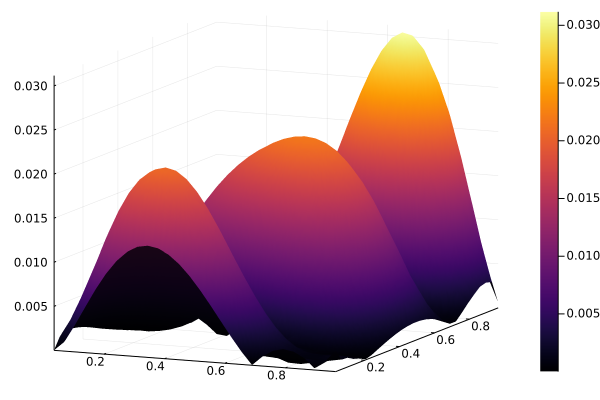

In [77]:
reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

#N_I*2
#cond(Matrix(G))
G = sparse(G)
println(reference_v)
sol = G\Global_RHS
error = abs.(sol - reference_v)
println("max error: ",maximum(error))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I])
#surface(I_points[1,:],I_points[2,:],sol[1:N_I])
surface(I_points[1,:],I_points[2,:],error[1:N_I])